In [ ]:
# Запуск простой программы Hello World! как Flask сервера

In [ ]:
!pip install flask-ngrok
!pip install flask==0.12.2

     |████████████████████████████████| 83 kB 1.0 MB/s 
  Attempting uninstall: flask
    Found existing installation: Flask 1.1.4
    Uninstalling Flask-1.1.4:
      Successfully uninstalled Flask-1.1.4


In [ ]:
%%writefile flask_app.py
# Чтобы получить внешний адрес виртуальной машины на которой запущен collab notebook используем библиотеку socket


# Импортируем Flask
from flask import Flask
from flask_ngrok import run_with_ngrok # эта строчка не нужна, если запускаете на своем ПК

# Задаем имя серверу
app = Flask(__name__)
run_with_ngrok(app) # эта строчка не нужна, если запускаете на своем ПК

# Указываем адрес по которому будет откликаться Web сервис и задаем саму функцию веб сервиса
@app.route("/")
def hello():
    return "Hello World!"

# Запускаем Web-сервис в виде отдельного процесса 'host':'0.0.0.0' указываем чтобы обеспечить листинг сервиса на внешнем сетевом интерфейсе  
#app.run('host':'0.0.0.0','port':80)
if __name__ == '__main__':
    app.run() 
    #app.run('host':'0.0.0.0','port':5000)

Writing flask_app.py


In [ ]:
!python flask_app.py

172.28.0.2
 * Serving Flask app "flask_app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
^C


Разбираем вывод:
http://6d19-35-201-198-110.ngrok.io  ** - внешний адрес Web сервера**
 * Serving Flask app "__main__" (lazy loading) - **Имя Web сервера**
 * Environment: production
   WARNING: This is a development server. Do not use it in a production deployment.
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://0.0.0.0:80/ (Press CTRL+C to quit) - Адрес и порт Web сервера, где 0.0.0.0 означает что сервер виден на внешнем интерфейсе

In [ ]:
# Запрашиваем веб сервер с клиентской стороны
import requests
r = requests.get("http://7dfd-35-237-198-104.ngrok.io/train") #REST API HTTP/HTTPS   GET/post
print(r.status_code)
print(r.encoding)
print(r.apparent_encoding)
print(r.text)

200
utf-8
ascii
Method should be POST


In [ ]:
# Получаем тот-же результат с помощью CURL
!curl -X GET  http://9c0d-35-237-198-104.ngrok.io/

Hello World!

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


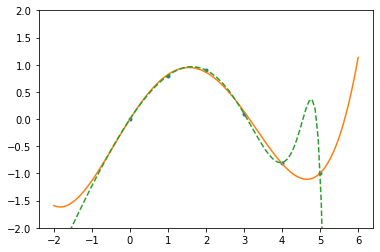

In [11]:
# Создадим x_train как массив случайных чисел заданной формы (3000,10)
import numpy as np


# Создадим Y как сложную нелинейную функцию от x
y = [1 if (i[1]/i[2]) > (i[3]/i[4])-(i[5]**2)+(i[6]**2) else 0 for i in x]

In [4]:
z

array([ 4.44766861e-13, -5.86945599e-13,  1.33333333e-01,  4.50000000e+01])

In [ ]:
# Сохраняем модель в функцию
def predict_model(x):
  return [1 if (i[1]/i[2]) > (i[3]/i[4])-(i[5]**2)+(i[6]**2) else 0 for i in x]

# Создаем Flask Приложение с вызовом модели

In [ ]:
%%writefile flask_app2.py
# Загружаем билиотеки
import flask
from flask import Flask, request, redirect,url_for, send_from_directory
import pandas as pd
import requests
import json
import os
import numpy as np
from flask_ngrok import run_with_ngrok # эта строчка не нужна, если запускаете на своем ПК
from werkzeug.utils import secure_filename

# Задаем имя серверу
app = Flask(__name__)
app.config['JSONIFY_PRETTYPRINT_REGULAR'] = False
app.config['UPLOAD_FOLDER'] = '/content/'
ALLOWED_EXTENSIONS = {'png','jpeg'}
run_with_ngrok(app) # эта строчка не нужна, если запускаете на своем ПК

# Загрузка модели

def predict_model(x):
  return [1 if (i[1]/i[2]) > (i[3]/i[4])-(i[5]**2)+(i[6]**2) else 0 for i in x]

def allowed_file(filename):
    return '.' in filename and \
           filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

@app.route('/uploads/<name>')
def download_file(name):
  return send_from_directory(app.config['UPLOAD_FOLDER'],name)



@app.route('/web', methods=['GET', 'POST'])
def upload_file():
    if request.method == 'POST':
        # check if the post request has the file part
        if 'file' not in request.files:
            flash('No file part')
            return redirect(request.url)
        file = request.files['file']
        # If the user does not select a file, the browser submits an
        # empty file without a filename.
        if file.filename == '':
            flash('No selected file')
            return redirect(request.url)
        if file and allowed_file(file.filename):
            filename = secure_filename(file.filename)
            file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))
            return redirect(url_for('download_file', name=filename))
    return '''
    <!doctype html>
    <title>Upload new File</title>
    <h1>Upload new File</h1>
    <form method=post enctype=multipart/form-data>
      <input type=file name=file>
      <input type=submit value=Upload>
    </form>
    '''



# Задаем функцию Predict
@app.route("/predict", methods=["GET","POST"])
def predict():
  data = {"success": False}
  params = flask.request.json
  if (params == None):
    params = flask.request.args

	# Если параметры найдены, создаем из них Pandas DataFrame
  if (params != None):
    x=pd.DataFrame.from_dict(params, orient='index').transpose().astype('int').values

  # Записываем значение prediction в data["prediction"]
  data["prediction"] = predict_model(x)
  #Записываем статус в data["success"]
  data["success"] = True
    
  #Возвращаем результат json format 
  return flask.jsonify(data) 

@app.route("/train", methods=["GET","POST"])
def retraining():

  if flask.request.method == 'POST':

    x = json.loads(flask.request.json)['train_x']
    y = json.loads(flask.request.json)['train_y']
    return flask.jsonify({'x':x}) #"mnist_new.h5"
  else:
    return "Method should be POST"

# Запускаем Сервер
if __name__ == '__main__':
    app.run() 



Overwriting flask_app2.py


In [ ]:
import requests
import json
data_all = {'train_x': x[0].tolist(), 'train_y' : x[1].tolist()}
#file = {'file': open('/content/flask_test.h5', 'rb')}
r = requests.post('http://c858-35-237-198-104.ngrok.io/train', json=json.dumps(data_all))

In [ ]:
import requests
import json
data_all = {'train_x': x[0].reshape(-1,784).tolist(), 'train_y' : x[1].tolist()}
file = {'file': open('/content/flask_test.h5', 'rb')}
r = requests.post('http://172.28.0.2:5004/train', json=json.dumps(data_all),files= file)

[2020-06-24 20:44:24,627] ERROR in app: Exception on /train [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.6/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.6/dist-packages/flask/app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-21-aa4aa2ea1082>", line 48, in retraining
    x = json.loads(flask.request.json)['tra

ConnectionError: ignored

In [ ]:
# импортируем библиотеку requests
import requests

# Создаем словарь dict с параметрами
data = {'key1': 0,
           'key2': 1,
          'key3': 1,
          'key4': 0,
          'key5': 1,
          'key6': 1,
          'key7': 0,
          'key8': 1,
          'key9': 1,
          'key10': 1,}

# Запрашиваем Web-сервис, передаем в запрос параметры
r = requests.get('http://ce11-35-237-198-104.ngrok.io/predict', params=data)

In [ ]:
# Смотрим ответ Web-сервиса
r.text

'{"prediction":[1],"success":true}\n'

# Домашнее задание

Задание **Light**:


1.   Напишите свою функцию predict_model следующего вида: y = x**2 + 1/x - log(x) * 1/2x**3
2. Измините функцию загрузки файлов таким образом чтобы можно было сохранять csv файлы. В функции upload_file после сохранения файла прочитайте его с помощью библиотеки pandas и выведите текст первых 2-х строчек файла вместо return redirect(url_for('download_file', name=filename))

Задание **PRO**:

1. Напишите метод fit, который на вход получает два массива значение x и y и обучает простую функцию np.polyfit, после чего сохраняет картинку с графиками исходной и приближенной функции и выводит ее в браузере
см. пример кода:
import numpy as np
x = np.array([0.0, 1.0, 2.0, 3.0,  4.0,  5.0])
y = np.array([0.0, 0.8, 0.9, 0.1, -0.8, -1.0])
z = np.polyfit(x, y, 4)


import matplotlib.pyplot as plt
p = np.poly1d(z)
p30 = np.poly1d(np.polyfit(x, y, 30))
xp = np.linspace(-2, 6, 100)
_ = plt.plot(x, y, '.', xp, p(xp), '-', xp, p30(xp), '--')
plt.ylim(-2,2)
(-2, 2)
plt.show()

2. Используя библиотеку Dash создайти приложение, в котором будет построен график на основе следующих данных:
https://github.com/ashishpatel26/Introduction-to-Time-Series-forecasting/blob/master/international-airline-passengers.csv
Добавьте Slider для выбора года и DropDown для выбора месяца, напишите callback функции для перерисовки графика после перемещения Slider или выбора в Dropdown


Результаты по ДЗ предоставить в виде ссылки на Google colaboratory ноутбук